<a href="https://colab.research.google.com/github/EinarLop/adaptive_reliability_evaluation_system_GCNN/blob/main/2M_3S_E3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install torch_geometric (everything else is pre-installed in Colab
# Add more rows if woring from Pycharm etc.)
! pip install torch_geometric
#Unzip the archive with data
!unzip results.zip

Archive:  results.zip
  inflating: configs.txt             
  inflating: config_0.mat            
 extracting: config_0.rel            
  inflating: config_1.mat            
  inflating: config_10.mat           
 extracting: config_10.rel           
  inflating: config_100.mat          
 extracting: config_100.rel          
  inflating: config_101.mat          
 extracting: config_101.rel          
  inflating: config_102.mat          
 extracting: config_102.rel          
  inflating: config_103.mat          
 extracting: config_103.rel          
  inflating: config_104.mat          
 extracting: config_104.rel          
  inflating: config_105.mat          
 extracting: config_105.rel          
  inflating: config_106.mat          
 extracting: config_106.rel          
  inflating: config_107.mat          
 extracting: config_107.rel          
  inflating: config_108.mat          
 extracting: config_108.rel          
  inflating: config_109.mat          
 extracting: config_109.rel 

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import numpy as np

In [ ]:
# Red all matrix files and convert them into a list of lists
mat_files = sorted(glob.glob('/content/*.mat'))
if '/content/config_1.mat' in mat_files:
    mat_files.remove('/content/config_1.mat')

all_matrices = []
for path in mat_files:
  with open(path, 'r') as f:
    content = f.read()
  # Remove the first and last character ('[' and ']')
  content = content[1:-1]
  string_list = []
  current_row = ''
  start_line = False
  for c in content:
      if c == '[':
          start_line = True
      elif c == ']':
          start_line = False
          string_list.append(current_row)
          current_row = ''
      elif start_line:
          if c != '\n':
              current_row += c
  matrix = []
  for string in string_list:
    vals = string.replace('.', ' ').split()
    vals = [int(v) for v in vals]
    matrix.append(vals)
  all_matrices.append(matrix)

In [ ]:
# Convert adjacency matrices into edge indices.
# An edge index is a 2 x Num_Of_Vert array. Here is an example
# [[ 1, 2, 2, 3],
#  [ 2, 1, 3, 2]]
# You read the list by pairing numbers from top row with numbers from bottom row
# In this example, 1 connects to 2, 2 connects to 1, 2 connects to 3,
# and 3 connects to 2.
# PyTorch Geometric works with this format of edge connection

# List to hold edge indices for all indices
all_edge_indices = []

# Process each matrix in the list
for matrix in all_matrices:
    # Convert the 2D list to a numpy array
    matrix_np = np.array(matrix)

    # Get the indices where there are edges (i.e., non-zero entries)
    edge_indices = np.nonzero(matrix_np)

    # Stack the indices into a 2xN array where each column represents an edge
    edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)

    # Append the edge_index tensor to the list
    all_edge_indices.append(edge_index)

In [ ]:
# Read target values from rel files
rel_files = sorted(glob.glob('/content/*.rel'))
all_rels = []
if '/content/config_1.rel' in rel_files:
    rel_files.remove('/content/config_1.rel')
for path in rel_files:
  with open(path, 'r') as f:
    y_val = float(f.read())
  all_rels.append(y_val)
# Convert the list of float values to a PyTorch tensor
all_rels_tensor = torch.tensor(all_rels)


In [ ]:
'''
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Convert list to a NumPy array
all_rels_array = np.array(all_rels)

# Reshape to 2D array (required for StandardScaler)
all_rels_scaled = scaler.fit_transform(all_rels_array.reshape(-1, 1))

# Convert the scaled values to a tensor
all_rels_tensor = torch.tensor(all_rels_scaled, dtype=torch.float)
'''

'\nimport numpy as np\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\n# Convert list to a NumPy array\nall_rels_array = np.array(all_rels)\n\n# Reshape to 2D array (required for StandardScaler)\nall_rels_scaled = scaler.fit_transform(all_rels_array.reshape(-1, 1))\n\n# Convert the scaled values to a tensor\nall_rels_tensor = torch.tensor(all_rels_scaled, dtype=torch.float)\n'

In [ ]:
# Create node features
# Create a dictionary based on the first row of configs.txt that maps an index tof the node to it type
# Define the mapping from prefixes to types
prefix_to_type = {
    'S': 'slave',
    'P': 'port',
    'L': 'link',
    'Pg': 'port guard',
    'Sw': 'switch'
}

# Initialize the dictionary to store the index to type mapping
index_to_type = {}

# Read the first line from 'configs.txt'
with open('configs.txt', 'r') as file:
    first_line = file.readline().strip()

# Extract the part after 'config_0: [' and before the closing ']'
start = first_line.find('[')
end = first_line.find(']')
node_list_str = first_line[start+1:end]

# Split the node names by comma and strip whitespace
node_names = [node.strip() for node in node_list_str.split(',')]

# Iterate over the node names and map index to type
for index, node_name in enumerate(node_names):
    # Check for multi-character prefixes first (e.g., 'Pg', 'Sw')
    if node_name.startswith('Pg'):
        node_type = 'port guard'
    elif node_name.startswith('Sw'):
        node_type = 'switch'
    else:
        # Use the first character as prefix
        prefix = node_name[0]
        node_type = prefix_to_type.get(prefix, 'unknown')
    # Map the index to the node type
    index_to_type[index] = node_type

type_failure_rates = {
    'slave': 0.00001,
    'port': 0.00000125537,
    'link': 0.0000001,
    'port guard': 0.00000125537,
    'switch': 0.000001

}
node_features = []
for node_type in index_to_type.values():
    node_features.append([type_failure_rates[node_type]])
node_features_tensor = torch.tensor(node_features)

In [ ]:
#Create one Data object per graph and put them into one list
# TODO: Create PyTOrch Geometric Dataset object (https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html)
# Each Data object should have node features in a tensor called X,
# (we dont' have any node features yet, that's why there are placeholders)
# target tensor called Y, and edge_index from before.
data_list = []
for i in range(len(all_matrices)):
  node_features = node_features_tensor
  edge_index = all_edge_indices[i]
  y = all_rels_tensor[i]

  data = Data(x=node_features, edge_index=edge_index, y=y)
  data_list.append(data)

In [ ]:
import random
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from sklearn.model_selection import train_test_split

# Split data and create DataLoader objects for training
train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features=1, dropout_rate=0.3):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.fc = torch.nn.Linear(16, 1)
        #self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GCN layer with dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, p=self.dropout_rate, training=self.training)  # Apply dropout

        # Second GCN layer with dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, p=self.dropout_rate, training=self.training)  # Apply dropout

        # Global mean pooling to get graph-level representation
        x = global_mean_pool(x, batch)  # Shape: [batch_size, hidden_channels]

        # Final fully connected layer with dropout
        #x = F.dropout(x, p=self.dropout_rate, training=self.training)  # Apply dropout
        x = torch.sigmoid(self.fc(x))
        return x


In [ ]:
import torch.optim as optim
import time
import os

model = GCN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

num_epochs = 10000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    avg_train_loss = total_loss / len(train_data_list)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            total_val_loss += loss.item() * data.num_graphs

    avg_val_loss = total_val_loss / len(test_data_list)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')



Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5002/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5003/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5004/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5005/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5006/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5007/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5008/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5009/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5010/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5011/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5012/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5013/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5014/10000, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 5015/10000, Training Loss: 0.0001

Mean Squared Error on Test Set: 0.0001


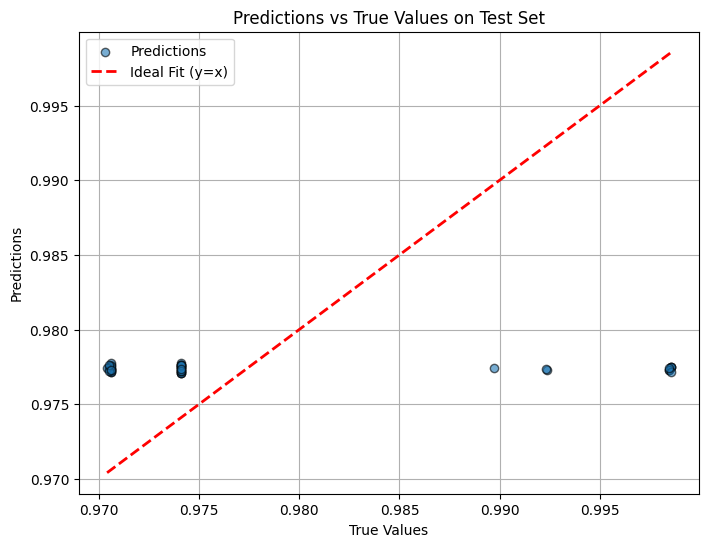

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Evaluate on test data
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for data in test_loader:
        out = model(data).squeeze()  # Predictions from the model
        predictions.append(out.cpu().numpy())  # Append predictions
        true_values.append(data.y.cpu().numpy())  # Append true values

# Flatten the lists
predictions = [item for sublist in predictions for item in sublist]
#predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
true_values = [item for sublist in true_values for item in sublist]
#true_values = scaler.inverse_transform(np.array(true_values).reshape(-1, 1))

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, predictions)

print(f'Mean Squared Error on Test Set: {mse:.4f}')

# Scatter Plot for Predictions vs True Values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)],
         'r--', lw=2, label='Ideal Fit (y=x)')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values on Test Set')
plt.legend()
plt.grid()
plt.show()


In [ ]:
print(predictions)
print(true_values)

[0.9923099, 0.9923099, 0.9915887, 0.9937329, 0.9937328, 0.9904171, 0.99447584, 0.9879805, 0.9887016, 0.9915887, 0.9923099, 0.9918575, 0.9911363, 0.9894228, 0.9937329, 0.9901246, 0.99113834, 0.99113834, 0.9923099, 0.990144, 0.9894229, 0.9923099, 0.990142, 0.991567, 0.98798037, 0.98798037, 0.9887016, 0.99256134, 0.99447584, 0.9915823, 0.9925612, 0.9894208, 0.9908632, 0.9937091, 0.990144, 0.9901246, 0.9915823, 0.98940337, 0.9937329, 0.9937329, 0.9887017, 0.9894228, 0.991567, 0.9908458]
[0.9741193, 0.9985338, 0.9741193, 0.9741193, 0.97060835, 0.9984458, 0.97060835, 0.9741193, 0.97060835, 0.9741193, 0.9985338, 0.97051364, 0.97051364, 0.97060835, 0.9741193, 0.97060835, 0.97060835, 0.97060835, 0.9741193, 0.9741193, 0.9741193, 0.9985338, 0.9923432, 0.97060835, 0.9741193, 0.9741193, 0.97060835, 0.97060835, 0.9741193, 0.9704145, 0.9741193, 0.97051364, 0.99232566, 0.97051364, 0.97060835, 0.9984458, 0.98970824, 0.9741193, 0.9741193, 0.9741193, 0.9985338, 0.9741193, 0.9984458, 0.9741193]
